<a href="https://colab.research.google.com/github/vndiaz1/vndiaz1-IIC3633-2020/blob/master/Pr%C3%A1cticos/Implicit_implicit_feedback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctico librería implicit - ALS y BPR

Clase: IIC3633 Sistemas Recomendadores, PUC Chile

In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    435      0 --:--:-- --:--:-- --:--:--   434
100 1546k  100 1546k    0     0  1070k      0  0:00:01  0:00:01 --:--:-- 1070k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    834      0 --:--:-- --:--:-- --:--:--   832
100  385k  100  385k    0     0   405k      0 --:--:-- --:--:-- --:--:--  405k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    744      0 --:--:-- --:--:-- --:--:--   743
100  230k  100  230k    0     0   234k      0 --:--:-- --:--:-- --:--:--  234k


In [2]:
!pip3 install implicit --upgrade

     |████████████████████████████████| 1.1MB 2.8MB/s 
  Created wheel for implicit: filename=implicit-0.4.2-cp36-cp36m-linux_x86_64.whl size=3420141 sha256=28294e7cc546f3bab3780318271be6f33e32d965f67dff37110ed8bc26eb045e
  Stored in directory: /root/.cache/pip/wheels/1b/48/b1/1aebe3acc3afb5589e72d3e7c3ffc3f637dc4721c1a974dff7
Successfully built implicit


In [4]:
import pandas as pd
import numpy as np
import implicit
import scipy.sparse as sparse

In [6]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [7]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]

In [8]:
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,1,878542960
1,1,4,1,876893119
2,1,5,1,889751712
3,1,6,1,887431973
4,1,7,1,875071561


In [9]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')

In [10]:
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [11]:
# Cargamos el dataset de testing
df_test = pd.read_csv('u2.test',
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0) 
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]


user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []
        
    user_items_test[row[1]].append(row[2])

In [12]:
df_test.head()

,userid,itemid,rating,timestamp
0,1,1,1,874965758
1,1,2,1,876893171
2,1,8,0,875072484
3,1,9,1,878543541
4,1,21,0,878542772


### Métricas

In [14]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])
  
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

### Preprocesamiento de los datos a formato sparse

In [15]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []
        
    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)
    
matrix = sparse.csr_matrix(sparse_matrix.T)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()

In [16]:
def evaluate_model(model, n):
  mean_map = 0.
  mean_ndcg = 0.
  for u in user_items_test.keys():
    rec = [t[0] for t in model.recommend(u, user_item_matrix, n)]
    rel_vector = [np.isin(user_items_test[u], rec, assume_unique=True).astype(int)]
    mean_map += mean_average_precision(rel_vector)
    mean_ndcg += ndcg_at_k(rel_vector, n)

  mean_map /= len(user_items_test)
  mean_ndcg /= len(user_items_test)
  
  return mean_map, mean_ndcg

In [17]:
def show_recommendations(model, user, n):
  recommendations = [t[0] for t in model.recommend(user, user_item_matrix, n)]
  return df_items.loc[recommendations]['title']

In [18]:
def show_similar_movies(model, item, n=10):
  sim_items = [t[0] for t in model.similar_items(item, n)]
  return df_items.loc[sim_items]['title']

## ALS (Implicit Feedback)

**Pregunta 1:** Explique brevemente cómo funciona el algoritmo ALS.

**Respuesta:** A partir de la matriz de *ratings* (o similar) se generan dos variables, p_ui (binaria que es 1 si u ha visto i) y c_ui (nivel de confianza que tiene p_ui según r_ui). Con estas variables, se utiliza la descomposición matricial y se minimiza mediante descenso de gradiente alternado, es decir, se dejan fijos los parámetros de los items para arreglar los param del usuario y luego al revés. Esto ayuda a reducir el costo computacional.

In [19]:
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=10, use_gpu=False)
model_als.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [20]:
show_recommendations(model_als, user=77, n=10)

movieid
256     When the Cats Away (Chacun cherche son chat) (...
754                                     Red Corner (1997)
409                                           Jack (1996)
258                                        Contact (1997)
257                                   Men in Black (1997)
1012                                 Private Parts (1997)
292                                       Rosewood (1997)
136                   Mr. Smith Goes to Washington (1939)
125                                     Phenomenon (1996)
273                                           Heat (1995)
Name: title, dtype: object

In [21]:
maprec, ndcg = evaluate_model(model_als, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.05974782748732627
ndcg: 0.33078101071975496


**Pregunta 2:** Pruebe distintos valores para los parámetros de ALS y muestre gráficos de cómo se ven afectadas las métricas recién mostradas.

In [23]:
# Sensibilización de # de factores
factores   = [50, 100, 150, 200, 250]
map_list   = list()
ndcg_list = list()
for fact in factores:
    model_als = implicit.als.AlternatingLeastSquares(factors=fact, iterations=10, use_gpu=False)
    model_als.fit(matrix)
    maprec, ndcg = evaluate_model(model_als, n=10)
    map_list.append(maprec)
    ndcg_list.append(ndcg)

Mostramos los resultados

Text(0.5, 1.0, 'ndcg@10 vs Factores latentes')

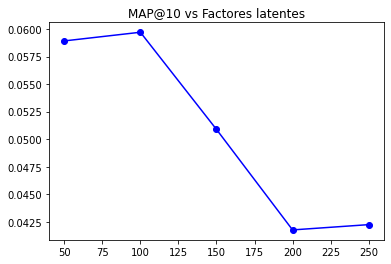

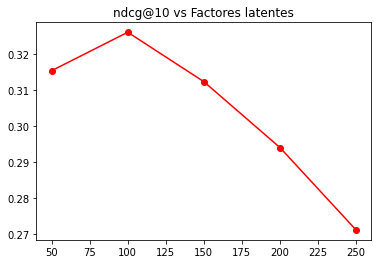

In [30]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(factores, map_list, "bo")
plt.plot(factores, map_list, "b")
plt.title("MAP@10 vs Factores latentes")

plt.figure(2)
plt.plot(factores, ndcg_list, "ro")
plt.plot(factores, ndcg_list, "r")
plt.title("ndcg@10 vs Factores latentes")

Se observa que con 100 factores se obtiene es mejor el rendimiento dadas ambas métricas. Por lo que se ocupará para el siguiente experimento.

In [37]:
# Sensibilización de # de iteraciones
iteraciones   = [5, 10, 15, 20, 25]
map_list   = list()
ndcg_list = list()
for it in iteraciones:
    model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=it, use_gpu=False)
    model_als.fit(matrix)
    maprec, ndcg = evaluate_model(model_als, n=10)
    map_list.append(maprec)
    ndcg_list.append(ndcg)

Text(0.5, 1.0, 'ndcg@10 vs iteraciones')

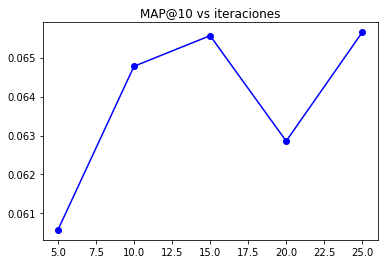

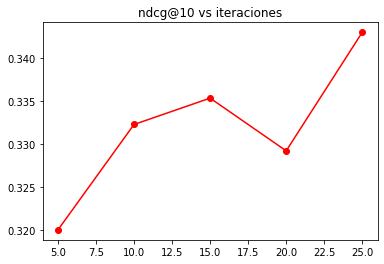

In [38]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(iteraciones, map_list, "bo")
plt.plot(iteraciones, map_list, "b")
plt.title("MAP@10 vs iteraciones")

plt.figure(2)
plt.plot(iteraciones, ndcg_list, "ro")
plt.plot(iteraciones, ndcg_list, "r")
plt.title("ndcg@10 vs iteraciones")

Se puede ver que con mayor cantidad de iteraciones, el modelo tiene un mejor desempeño.

## BPR

**Pregunta 3:** Explique con sus palabras la intuición del framework BPR.

**Respuesta:** En vez de utilizar optimización para minimizar el error de predicción, BPR utiliza el criterio bayesiano para maximizar la diferencia entre los ratings de cada par de items para tener una mejor recomendación del tipo top-N. Así ocupar su criterio de máxima verosimilitud que es análogo a maximizar la métrica de AUC que se refiere de forma simple a la tasa de recomendaciones acertadas en un top-N. Al hacerlo de modo general, se puede ocupar cualquier modelo de recomendación y este sólo ocupa su framework de optimización y aprendizaje.

In [33]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=40, use_gpu=False)
model_bpr.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [34]:
show_recommendations(model_bpr, user=77, n=10)

movieid
257      Men in Black (1997)
299           Hoodlum (1997)
285    Secrets & Lies (1996)
327          Cop Land (1997)
332    Kiss the Girls (1997)
746       Real Genius (1985)
267                  unknown
676     Crucible, The (1996)
331         Edge, The (1997)
301          In & Out (1997)
Name: title, dtype: object

In [35]:
show_similar_movies(model_bpr, item=171, n=10)

movieid
171              Delicatessen (1991)
209        This Is Spinal Tap (1984)
21     Muppet Treasure Island (1996)
68                  Crow, The (1994)
203                Unforgiven (1992)
27                   Bad Boys (1995)
78                 Free Willy (1993)
194                Sting, The (1973)
173       Princess Bride, The (1987)
201              Evil Dead II (1987)
Name: title, dtype: object

In [36]:
maprec, ndcg = evaluate_model(model_bpr, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.04538580879805616
ndcg: 0.35834609494640124


**Pregunta 4:** Pruebe distintos valores para los parámetros de BPR y muestre gráficos de cómo se ven afectadas las métricas recién mostradas.

In [44]:
# Sensibilización de # de factores
factores   = [100, 200, 300, 400, 500]
map_list   = list()
ndcg_list = list()
for fact in factores:
    model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=fact, iterations=40, use_gpu=False)
    model_bpr.fit(matrix)
    maprec, ndcg = evaluate_model(model_bpr, n=10)
    map_list.append(maprec)
    ndcg_list.append(ndcg)

Text(0.5, 1.0, 'ndcg@10 vs Factores latentes')

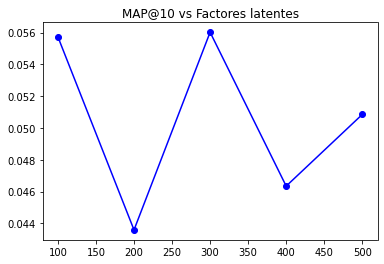

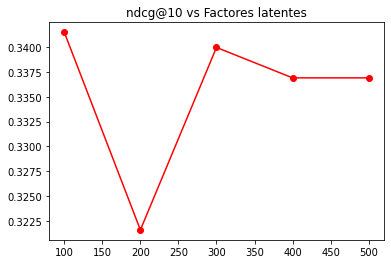

In [45]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(factores, map_list, "bo")
plt.plot(factores, map_list, "b")
plt.title("MAP@10 vs Factores latentes")

plt.figure(2)
plt.plot(factores, ndcg_list, "ro")
plt.plot(factores, ndcg_list, "r")
plt.title("ndcg@10 vs Factores latentes")

Al parecer con 300 factores se tiene uno de los mejores desempeños de acuerdo a las métricas utilizadas.

In [46]:
# Sensibilización de # de iteraciones
iteraciones   = [30, 40, 50, 60]
map_list   = list()
ndcg_list = list()
for it in iteraciones:
    model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=300, iterations=it, use_gpu=False)
    model_bpr.fit(matrix)
    maprec, ndcg = evaluate_model(model_bpr, n=10)
    map_list.append(maprec)
    ndcg_list.append(ndcg)

Text(0.5, 1.0, 'ndcg@10 vs iteraciones')

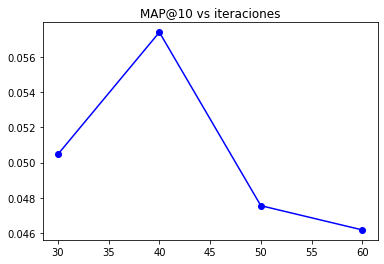

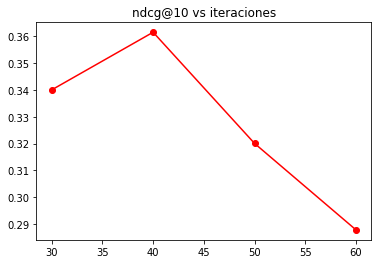

In [47]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(iteraciones, map_list, "bo")
plt.plot(iteraciones, map_list, "b")
plt.title("MAP@10 vs iteraciones")

plt.figure(2)
plt.plot(iteraciones, ndcg_list, "ro")
plt.plot(iteraciones, ndcg_list, "r")
plt.title("ndcg@10 vs iteraciones")

Se ve claramente que con 40 iteraciones el modelo tiene el mejor rendimiento.